In [572]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as scp
from scipy import optimize
from scipy import special
from scipy import stats
from itertools import product
import xarray 
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

def sample(func,params,rate):
    searching = True
    time = 0
    while searching:
        nextPassage = func(*params)
        nextRate = np.random.exponential(1/rate)
        if nextRate>nextPassage:
            searching = False
            time += nextPassage
        else:
            time += nextRate
    return time

def padeTr4_3(x,A,U1,D1,U2,D2,U3,D3,D4):
    Tr = (U3*x**3+U2*x**2+x*U1+A)/(D4*x**4+D3*x**3+D2*x**2+x*D1+A)
    return (1-Tr)/(Tr*x)

def pade3_2_forLaplace(x,A,U1,D1,U2,D2,D3):
    return (U2*x**2+x*U1+A)/(D3*x**3+D2*x**2+x*D1+A)

def pade3_2(x,U0,U1,D1,U2,D2,D3):
    return (U2*x**2+x*U1+U0)/(D3*x**3+D2*x**2+x*D1+1)

def pade4_3_forLaplace(x,A,U1,D1,U2,D2,U3,D3,D4):
    return (U3*x**3+U2*x**2+x*U1+A)/(D4*x**4+D3*x**3+D2*x**2+x*D1+A)

def pade4_3(x,U0,D0,U1,D1,U2,D2,U3,D3,D4):
    return (U3*x**3+U2*x**2+x*U1+U0)/(D4*x**4+D3*x**3+D2*x**2+x*D1+D0)

def IGLaplace(rs,L,D,V):
    return np.exp(L/(2*D)*(V-np.sqrt(V**2+4*D*rs)))
# samples = scp.stats.invgauss.rvs(CV,scale=1/CV, size=100000)
# Trs = np.array([sum(np.exp(-samples*r))/len(samples) for r in rs])
# mus = (1-Trs)/(rs*Trs)
# plt.plot(rs,mus,label="Exact")

0.8871497875706578

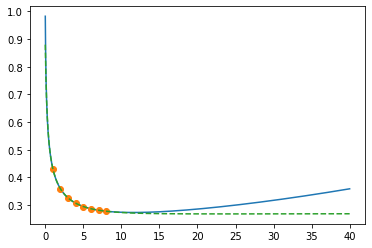

In [260]:
CV = 10
rate = 
fitFunction = pade4_3
rs = np.linspace(0,40,10000)
Trs = IGLaplace(rs,1,CV/2,1)
mus = (1-Trs)/(rs*Trs)
plt.plot(rs,mus,label="Exact")

selrs = np.linspace(rate,rate*8,8)
selTrs = IGLaplace(selrs,1,CV/2,1)
selmus = (1-selTrs)/(selrs*selTrs)
plt.plot(selrs,selmus,"o",label="Exact")

# fitMus = scp.optimize.curve_fit(fitFunction, selrs, selmus,bounds=(0,np.inf))
# preMus = fitFunction(rs,*fitMus[0])
# plt.plot(rs,preMus,linestyle="dashed")

fitTrs  = scp.optimize.curve_fit(pade4_3_forLaplace, selrs, selTrs,bounds=(0,np.inf))
fittedTrs = pade4_3_forLaplace(rs,*fitTrs[0])
preTrs = (1-fittedTrs)/(rs*fittedTrs)
plt.plot(rs,preTrs,linestyle="dashed")
(fitTrs[0][2]-fitTrs[0][1])/fitTrs[0][0]

(0.7169477914400055, array([ 2.,  4.,  6.,  8., 10., 12., 14.]))

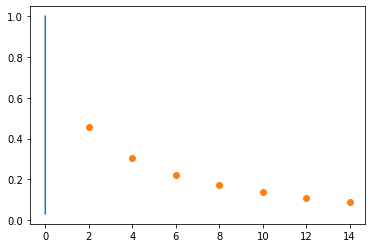

In [495]:
rate = 2
selrs = np.linspace(rate,rate*7,7)
selTrs = IGLaplace(selrs,1,CV/2,1)
# selTrs = np.insert(selTrs,0,1)
# selrs = np.insert(selrs,0,0)
plt.plot(rs,Trs)
plt.plot(selrs,selTrs,"o",label="Exact")
fitTrs  = scp.optimize.curve_fit(pade3_2_forLaplace, selrs, selTrs,bounds=(0,np.inf))
fittedTrs = pade3_2_forLaplace(rs,*fitTrs[0])
plt.plot(rs,fittedTrs,linestyle="dashed")
(fitTrs[0][2]-fitTrs[0][1])/fitTrs[0][0], selrs
# plt.xlim(0,1)
# selTrs

7.965393173492257e-08

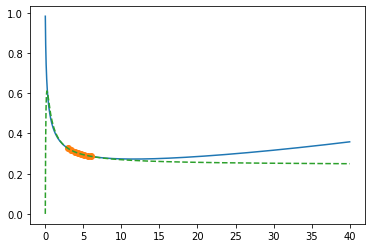

In [395]:
CV = 10
rate = 3
fitFunction = pade3_2
rs = np.linspace(0,40,10000)
Trs = IGLaplace(rs,1,CV/2,1)
mus = (1-Trs)/(rs*Trs)
plt.plot(rs,mus,label="Exact")

selrs = np.linspace(rate,rate*2,8)
selTrs = IGLaplace(selrs,1,CV/2,1)
selmus = (1-selTrs)/(selrs*selTrs)
plt.plot(selrs,selmus,"o",label="Exact")

fit = scp.optimize.curve_fit(pade3_2, selrs, selmus,bounds=(0,np.inf))
fitted = pade3_2(rs,*fit[0])
plt.plot(rs,fitted,linestyle="dashed")
fitted[0]

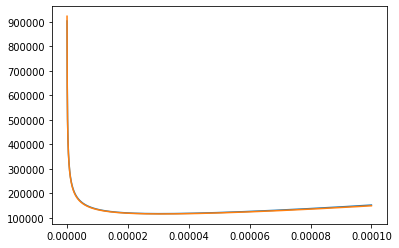

In [597]:
mu = 1000000
CV = 5
D = 0.5*mu*CV**2
m = 2*D/mu
s = mu/m
rs = np.linspace(0,0.0001,10000)
Trs = IGLaplace(rs,mu,D,1)
mus = (1-Trs)/(rs*Trs)
plt.plot(rs,mus,label="Exact")

samples = scp.stats.invgauss.rvs(m,scale=s, size=10000)
Trs = np.array([sum(np.exp(-samples*r))/len(samples) for r in rs])
mus = (1-Trs)/(rs*Trs)
plt.plot(rs,mus,label="Exact")

In [603]:
datalist = []
delta = 1
for rate in np.linspace(1e-7,1e-7*20,20):
    selrs = np.linspace(rate,rate*delta*10-(delta-1)*rate,10)
    selTrs = IGLaplace(selrs,mu,D,1)
    selTrs = np.insert(selTrs,0,1)
    selrs = np.insert(selrs,0,0)
    fitTrs = scp.optimize.curve_fit(pade4_3_forLaplace, selrs, selTrs,bounds=(0,np.inf))
    Trs = IGLaplace(rate,mu,D,1)
    mus = (1-Trs)/(rate*Trs)
    prediction = (fitTrs[0][2]-fitTrs[0][1])/fitTrs[0][0]
    datalist.append(pd.DataFrame(dict(rate = [0.001/rate],delta=delta,meanTr = mus/1000, 
                                      improvement = 1e6/mus, prediction = prediction/1000, error = abs(1e6-prediction)/1e4)))

data = pd.concat(datalist)
data

,rate,delta,meanTr,improvement,prediction,error
0,10000.000000,1,596.933668,1.675228,565.718818,43.428118
0,5000.000000,1,485.470690,2.059857,765.687850,23.431215
0,3333.333333,1,424.989505,2.352999,655.595377,34.440462
0,2500.000000,1,385.198667,2.596063,648.451053,35.154895
0,2000.000000,1,356.336214,2.806338,332.860135,66.713986
0,1666.666667,1,334.111520,2.993013,560.865558,43.913444
0,1428.571429,1,316.289655,3.161659,552.913053,44.708695
0,1250.000000,1,301.571861,3.315959,513.634660,48.636534
0,1111.111111,1,289.142982,3.458497,524.513696,47.548630
0,1000.000000,1,278.461162,3.591165,494.099186,50.590081


<AxesSubplot:xlabel='improvement', ylabel='error'>

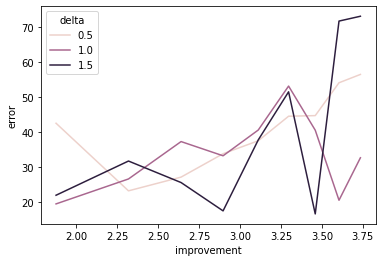

In [582]:
sns.lineplot(data=data.reset_index(),x="improvement",y="error",hue="delta")

In [642]:


def expansion(x,x0,delta,vals):

    first = (-49/20*vals[0] + 6*vals[1] -15/2*vals[2] + 20/3*vals[3] -15/4*vals[4] + 6/5*vals[5] -1/6*vals[6])/delta
    second = (469/90*vals[0] -223/10*vals[1] +879/20*vals[2] -949/18*vals[3] +41*vals[4] -201/10*vals[5] +1019/180*vals[6]-7/10*vals[7])/(delta**2)
    third = (-801/80*vals[0] +349/6*vals[1] -18353/120*vals[2] +2391/10*vals[3] -1457/6*vals[4] +4891/30*vals[5] -561/8*vals[6]+527/30*vals[7]-469/240*vals[8])/(delta**3)
    fourth = (1069/80*vals[0] -1316/15*vals[1] +15289/60*vals[2] -2144/5*vals[3] +10993/24*vals[4] -4772/15*vals[5] +2803/20*vals[6]-536/15*vals[7]+967/240 *vals[8])/(delta**4)
    
    return vals[0] + first*(x-x0) + second*(x-x0)**2/2 + third*(x-x0)**3/6 + fourth*(x-x0)**4/24,vals[0]

delta = 1e-8
rate = 10e-7
rs = np.array([rate+i*delta for i in range(10)])
Trs = IGLaplace(rs,mu,D,1)
mus = (1-Trs)/(rs*Trs)
expansion(0,rate,delta,mus)

(540469.9138988897, 278461.1615403837)